In [9]:
import pandas as pd
import numpy as np
import json
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
sns.set_style('whitegrid')
plt.style.use('Cole_2018.mplstyle')

# 1. Load data

In [10]:
df_pod_raw = pd.read_csv('/gh/data/personal-data-requests/apple/Podcasts Playstate.csv')
df_pod_raw.head()

,Feed URL,Episode ID,Visible?,Marked as played on,Manually set,Is New?,Last played on,Playback position,Play count,Has been played?
0,http://adversariallearning.libsyn.com/rss,20fdfc9de1c5bb500ef66f5387efe658,NaN,NaN,Yes,No,NaN,NaN,NaN,NaN
1,http://adversariallearning.libsyn.com/rss,47d0cf4b413af5ed37afcd188e5074e6,NaN,2017-06-07T01:06:29.252Z,Yes,No,2017-06-06T15:30:56.652Z,0.0,1.0,Yes
2,http://adversariallearning.libsyn.com/rss,4e8a976b06e60b9045ecf6f6a8ce0c2e,NaN,NaN,Yes,No,NaN,NaN,NaN,NaN
3,http://adversariallearning.libsyn.com/rss,5b7b0f72bce019d4dba02ea6f222d88a,NaN,NaN,Yes,No,NaN,NaN,NaN,NaN
4,http://adversariallearning.libsyn.com/rss,677cd6736d739d7f04fbc8092a650bef,NaN,NaN,Yes,No,NaN,NaN,NaN,NaN


# 2. Process podcasts
* Did an investigation, and some of the episodes I played do not show up as a full play count, so do some complicated stuff
* Note ThisAmericanLife is not tracked

In [11]:
df_pod_raw['Feed URL'].value_counts()

http://joeroganexp.joerogan.libsynpro.com/rss                              1472
http://rss.art19.com/the-daily                                              655
http://feeds.feedburner.com/soundcloud/mudw                                 400
http://feeds.99percentinvisible.org/99percentinvisible                      395
http://mbmbam.libsyn.com/rss                                                304
http://feeds.feedburner.com/HarmontownPodcast                               262
http://feeds.podtrac.com/zKq6WZZLTlbM                                       259
http://dataskeptic.libsyn.com/rss                                           257
http://feeds.soundcloud.com/users/soundcloud:users:156542883/sounds.rss     198
http://mathfactor.uark.edu/mathfactor/MathFactor.xml                        196
http://www.espn.com/espnradio/podcast/feeds/itunes/podCast?id=14554755      194
http://revolutionspodcast.libsyn.com/rss                                    179
https://www.npr.org/rss/podcast.php?id=5

In [12]:
# Convert url to podcast name
str_to_name = {'99perce': '99% Invisible',
               'www.npr.org/rss/podcast.php?id=510313': 'How I Built This',
               'partiallyderivative': 'Partially Derivative',
               'InternetExplorer': 'InternetExplorer',
               'serialpodcast': 'Serial',
               'replyall': 'Reply All',
               'joerogan': 'Joe Rogan',
               'sciencevs': 'Science Vs',
               'feeds.feedburner.com/soundcloud/mudw': 'If I Were You',
               'dataskeptic': 'Data Skeptic',
               'everythingisalive': 'Everything is Alive',
                'the-daily': 'The Daily',
               'feeds.podtrac.com/zKq6WZZLTlbM': 'The Daily',
               'feeds.soundcloud.com/users/soundcloud:users:377136647/sounds.rss': 'The Anthropocene Reviewed',
               'dr-death': 'Dr. Death',
               'thisamericanlife': 'This American Life',
               'feeds.soundcloud.com/users/soundcloud:users:156542883/sounds.rss': 'Dear Hank and John'
              }

def get_podcast_name(http):
    for (k, v) in str_to_name.items():
        if k in http:
            return v
    return 'other'

# Load and process podcast df
df_pod_raw['podcast_name'] = df_pod_raw['Feed URL'].apply(get_podcast_name)

In [13]:
# Only get podcasts played
df_pod = df_pod_raw.copy()
df_pod['played1'] = df_pod_raw['Has been played?'] == 'Yes'
df_pod['played2'] = ~df_pod_raw['Marked as played on'].isnull()
df_pod['played3'] = ~df_pod_raw['Last played on'].isnull()
df_pod['played4'] = df_pod_raw['Play count'] >= 1
df_pod['played'] = df_pod[['played1', 'played2', 'played3', 'played4']].sum(axis=1) >= 1
df_pod['dt_marked'] = pd.to_datetime(df_pod['Marked as played on'])
df_pod['dt_last'] = pd.to_datetime(df_pod['Last played on'])
df_pod['dt'] = df_pod['dt_last'].combine_first(df_pod['dt_marked'])
cols_keep = ['dt', 'podcast_name', 'played']
df_pod = df_pod[cols_keep].sort_values(by='dt').reset_index(drop=True)
df_pod.head()

,dt,podcast_name,played
0,2015-12-04 07:46:15.575,other,True
1,2015-12-04 08:39:16.719,other,True
2,2015-12-07 02:57:01.089,other,True
3,2015-12-15 01:52:44.226,other,True
4,2015-12-21 22:56:35.344,other,True


In [14]:
# Only get played podcasts
df_pod_played = df_pod.loc[df_pod['played'] & (~df_pod['dt'].isnull()), ['dt', 'podcast_name']].reset_index(drop=True)
df_pod_played.head()

,dt,podcast_name
0,2015-12-04 07:46:15.575,other
1,2015-12-04 08:39:16.719,other
2,2015-12-07 02:57:01.089,other
3,2015-12-15 01:52:44.226,other
4,2015-12-21 22:56:35.344,other


### 3. Most played podcasts

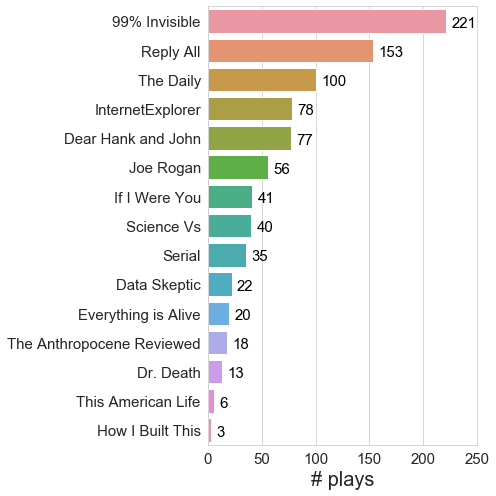

In [17]:
# Prep data to plot
df_plt2a = df_pod_played[df_pod_played['podcast_name']!='other']['podcast_name'].value_counts(
    ).reset_index().rename(columns={'index': 'podcast', 'podcast_name': 'n_plays'})


# Plot bars
plt.figure(figsize=(7,7))
g=sns.barplot(x='n_plays', y='podcast', data=df_plt2a)

# Plot numbers
for index, row in df_plt2a.iterrows():
    g.text(x=row['n_plays'] + 5,
           y=index + .2,
           s=row['n_plays'],
           color='black',
           ha="left",
           size=15
          )

plt.ylabel('')
plt.xlabel('# plays')
plt.xlim((0,250))
plt.tight_layout()

plt.savefig('/gh/srcole.github.io/assets/personaldata/apple_podcast_counts.png')

### 3b. Podcasts over time

/Users/scott/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


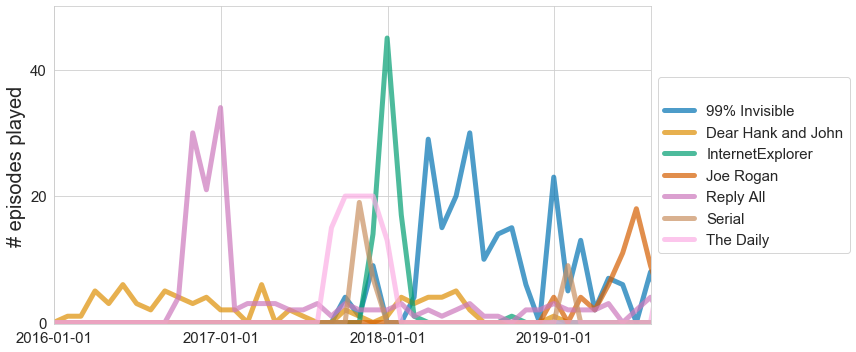

In [20]:
podcasts_plt = list(df_plt2a.loc[df_plt2a['n_plays']>50, 'podcast'].values) + ['Serial', 'Internet Explorer']
df_plt = df_pod_played[df_pod_played['podcast_name'].isin(podcasts_plt)]
df_plt['month_year'] = df_plt['dt'].dt.round('d') + pd.offsets.MonthEnd(0)

df_plt = df_plt.groupby(['month_year', 'podcast_name'])['dt'].count().reset_index().rename(columns={'dt': 'count'})
df_plt = df_plt.pivot(index='month_year', columns='podcast_name', values='count').fillna(0)
df_plt = df_plt.reindex(pd.date_range('2015-12-31', '2019-08-31', freq='M')).fillna(0).stack().reset_index()
df_plt = df_plt.rename(columns={'level_0': 'date', 'podcast_name': 'podcast', 0: 'count'})

plt.figure(figsize=(12,5))
sns.lineplot(x='date', y='count', data=df_plt, hue='podcast', linewidth=5, alpha=.7,
             palette=sns.color_palette("colorblind", n_colors=df_plt['podcast'].nunique())
            )
plt.xticks([datetime.datetime(x, 1, 1) for x in range(2016,2021)])
plt.xlim(datetime.datetime(2016, 1, 1), datetime.datetime(2019, 8, 1))
plt.yticks(np.arange(0,101,20))
plt.ylim((-.2,50))
plt.xlabel('')
plt.ylabel('# episodes played')

# # Format legend
leg = plt.legend(fontsize=15, loc='center left', bbox_to_anchor=(1,.5))
leg.texts[0].set_text(None)
for line in leg.get_lines():
    line.set_linewidth(5)
    line.set_alpha(.7)
plt.tight_layout()
    
plt.savefig('/gh/srcole.github.io/assets/personaldata/apple_podcast_temporal.png')